Task 1

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from queue import Queue

def es_color_similar(pixel, color_objetivo, tolerancia=30):
    return all(abs(pixel[i] - color_objetivo[i]) <= tolerancia for i in range(3))

def es_pared(pixel, umbral):
    return np.all(pixel[:3] <= umbral)  # Ignorar canal alfa si está presente

def es_posicion_valida(pos, forma_laberinto, paredes):
    i, j = pos
    return 0 <= i < forma_laberinto[0] and 0 <= j < forma_laberinto[1] and pos not in paredes

def bfs(laberinto_array, inicio, metas, paredes):
    forma_laberinto = laberinto_array.shape[:2]
    cola = Queue()
    cola.put([inicio])
    visitados = set()
    visitados.add(inicio)

    while not cola.empty():
        camino = cola.get()
        posicion_actual = camino[-1]

        if posicion_actual in metas:
            return camino
        
        for movimiento in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            proxima_posicion = (posicion_actual[0] + movimiento[0], posicion_actual[1] + movimiento[1])
            
            if es_posicion_valida(proxima_posicion, forma_laberinto, paredes) and proxima_posicion not in visitados:
                visitados.add(proxima_posicion)
                cola.put(camino + [proxima_posicion])

    return None

# Cargar la imagen del laberinto
imagen_laberinto = Image.open('Test2.bmp')  
laberinto_array = np.array(imagen_laberinto)

# Definir colores en formato RGB
color_pared = [0, 0, 0]  # Negro
color_inicio = [255, 0, 0]  # Rojo
color_meta = [0, 255, 0]  # Verde
color_camino = [255, 192, 203]  # Rosa para el camino solución

# Identificar el punto de inicio y las metas
posicion_inicio = None
posiciones_meta = []
for i in range(laberinto_array.shape[0]):
    for j in range(laberinto_array.shape[1]):
        if es_color_similar(laberinto_array[i, j], color_inicio):
            posicion_inicio = (i, j)
        elif es_color_similar(laberinto_array[i, j], color_meta):
            posiciones_meta.append((i, j))

# Establecer un umbral para detectar paredes
umbral_pared = 50

# Identificar paredes
conjunto_paredes = set()
for i in range(laberinto_array.shape[0]):
    for j in range(laberinto_array.shape[1]):
        if es_pared(laberinto_array[i, j], umbral_pared):
            conjunto_paredes.add((i, j))

# el inicio y las metas no se consideren paredes
conjunto_paredes.discard(posicion_inicio)
for meta in posiciones_meta:
    conjunto_paredes.discard(meta)

# Encontrar el camino
solucion_camino = bfs(laberinto_array, posicion_inicio, posiciones_meta, conjunto_paredes)

if solucion_camino:
    # Dibujar el camino solución en la imagen
    for posicion in solucion_camino:
        laberinto_array[posicion[0], posicion[1]] = color_camino

    # Convertir el arreglo a imagen y mostrar
    imagen_solucion = Image.fromarray(laberinto_array)
    plt.imshow(imagen_solucion)
    plt.axis('off')
    plt.show()
else:
    print("No se encontró un camino solución.")


# Task 1.1
Discretización de la imagen

In [ ]:
! pip install opencv-contrib-python

In [52]:
import numpy as np
def is_gray(color, threshold):
    """Check if a color is considered gray.

    Args:
        color: A tuple representing the RGB values of the color.
        threshold: The threshold for considering the color as gray.

    Returns:
        True if the color is considered gray, False otherwise.
    """
    return all(abs(color[i] - color[(i + 1) % 3]) < threshold for i in range(3))

def convert_image_to_cells(image, cell_size):
    """Converts an image to cells based on color.

    Args:
        image: A NumPy array representing the image.
        cell_size: The size of each cell in pixels.

    Returns:
        A NumPy array representing the cells, where each element is the average color
        of the corresponding cell in the original image.
    """

    # Check if the image is a 3-channel BGR image
    if len(image.shape) != 3 or image.shape[2] != 3:
        raise ValueError("Image must be a 3-channel BGR image.")

    height, width = image.shape[:2]  # Unpack the width and height
    cells = np.zeros((height // cell_size, width // cell_size, 3), dtype=np.uint8)

    for i in range(height // cell_size ):
        for j in range(width // cell_size):
            # Get the slice of the image corresponding to the current cell
            cell_image = image[i * cell_size : (i + 1) * cell_size,
                               j * cell_size : (j + 1) * cell_size]

            # Calculate the average color of the cell
            cell_color = np.mean(cell_image, axis=(0, 1))

            # Define the threshold values for each color
            green_threshold = 100
            black_threshold = 150
            red_threshold = 100

            # Check if the average color falls within the threshold ranges
            if (cell_color[0] <= black_threshold and
                cell_color[1] <= black_threshold and
                cell_color[2] <= black_threshold):
                # If the color is close to black, assign black
                cell_color = [0, 0, 0]
            elif (cell_color[0] < red_threshold and
                  cell_color[1] > green_threshold and 
                  cell_color[2] < red_threshold):
                # If the color is close to green, assign green
                cell_color = [6, 252, 6]
            elif (cell_color[0] < red_threshold and
                  cell_color[1] < green_threshold and 
                  cell_color[2] > red_threshold - 80):
                # If the color is close to red, assign red
                cell_color = [4, 4, 252]
            else:
                # If the color does not match any of the specified colors, assign white
                cell_color = [255, 255, 255]

            # Assign the color to the corresponding cell in the output array
            cells[i, j] = cell_color

    return cells


In [ ]:
import cv2


# Load the image
image = cv2.imread('Test.bmp')

# Convert the image to cells
cells = convert_image_to_cells(image, cell_size=4)

# Save the cells to a file (optional)
cv2.imwrite("cells_Test.bmp", cells)

print(cells.shape)


(145, 145, 3)


# Task 1.2
Framework de problemas

In [ ]:
#clase abstracta para los modelos, llamada pathfinder
# abstract base class work 
from abc import ABC, abstractmethod
from typing import List, Tuple

class Pathfider (object):
    def _init_ (self,image_matrix, tarjet_color , start_color):
        self.image_matrix = image_matrix
        self.tarjet_color = tarjet_color
        self.start_color = start_color
        self.steps = [] #guardar cada pasito ( aka toda la matriz por coloreado del path y nodos explorados)
        self.start = None
    
    @abstractmethod
    def findPath (self) -> Tuple[List[np.array], np.ndarray]:
        pass

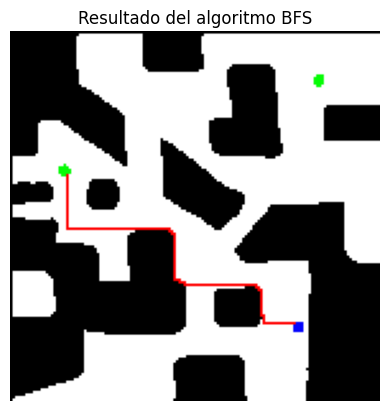

<Figure size 640x480 with 0 Axes>

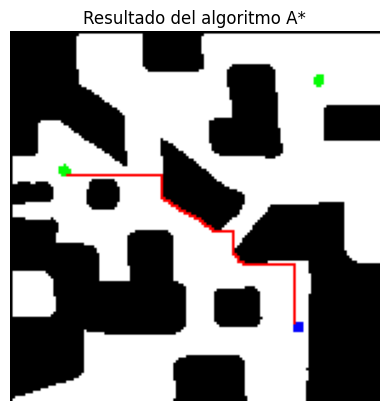

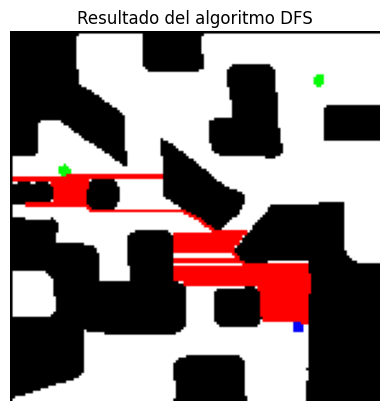

In [10]:
from abc import ABC, abstractmethod
from typing import List, Tuple
import numpy as np
from numpy.core.multiarray import array as array
from collections import deque  # Para usar colas en BFS
from discreta import *
import matplotlib.pyplot as plt


class Pathfinder(ABC):
    def __init__(self, image_matrix, target_color, start_color):
        self.image_matrix = image_matrix
        self.target_color = target_color
        self.start_color = start_color
        self.steps = []  # Guardar cada paso
        self.start = None
        self.end = None
        self.find_start_and_end()  # Encuentra las posiciones de inicio y final al instanciar

    def find_start_and_end(self):
        rows, cols, _ = self.image_matrix.shape
        for i in range(rows):
            for j in range(cols):
                if (self.image_matrix[i, j] == self.start_color).all():
                    self.start = (i, j)
                elif (self.image_matrix[i, j] == self.target_color).all():
                    self.end = (i, j)
                if self.start and self.end:
                    return  # Salir si ambos, inicio y final, son encontrados

class BFS(Pathfinder):
    def es_color_similar(self, pixel, color_objetivo, tolerancia=30):
        return all(abs(pixel[i] - color_objetivo[i]) <= tolerancia for i in range(3))

    def es_pared(self, pixel, umbral=50):
        return np.all(pixel[:3] <= umbral) 

    def es_posicion_valida(self, pos, visitados):
        i, j = pos
        rows, cols, _ = self.image_matrix.shape
        return 0 <= i < rows and 0 <= j < cols and pos not in visitados and not self.es_pared(self.image_matrix[i, j])

    def findPath(self) -> Tuple[List[np.array], np.ndarray]:
        if self.start is None or self.end is None:
            return [], None  

        rows, cols, _ = self.image_matrix.shape
        visited = set()
        queue = deque([(self.start, [self.start])])  # Cola para BFS, contiene pares (posición, camino)

        while queue:
            (current, path) = queue.popleft()
            x, y = current

            if (x, y) in visited:
                continue

            # Marcar como visitado
            visited.add((x, y))
            # Añadir el estado actual a los pasos
            self.steps.append((path, self.image_matrix.copy()))

            # Revisar si hemos llegado al final
            if self.es_color_similar(self.image_matrix[x, y], self.target_color):
                return self.steps, np.array(path)

            # Agregar vecinos a la cola
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # Arriba, abajo, izquierda, derecha
                nx, ny = x + dx, y + dy
                if self.es_posicion_valida((nx, ny), visited):
                    queue.append(((nx, ny), path + [(nx, ny)]))

        return [], None  # No se encontró camino



    
original_image = cv2.imread('Test.bmp') 
discrete_image = convert_image_to_cells(original_image, cell_size=4)  
pf_bfs = BFS(discrete_image, [4, 4, 252], [6, 252, 6])  # Instancia de BFS con la imagen procesada
res_bfs = pf_bfs.findPath()  # Ejecución de la búsqueda BFS


if res_bfs:
    steps_bfs, final_path_bfs = res_bfs
    image_for_bfs = np.copy(discrete_image) 
    if final_path_bfs is not None:
        for position in final_path_bfs:
            x, y = position
            image_for_bfs[x, y] = [255, 0, 0] 

        plt.figure()  
        plt.imshow(image_for_bfs)
        plt.axis('off') 
        plt.title('Resultado del algoritmo BFS')
        plt.show()
else:
    print("No se encontró un camino con BFS.")

import heapq  # Necesario para la cola de prioridad en A*
class AStar(Pathfinder):
    def es_color_similar(self, pixel, color_objetivo, tolerancia=30):
        return all(abs(pixel[i] - color_objetivo[i]) <= tolerancia for i in range(3))

    def es_pared(self, pixel, umbral=50):
        return np.all(pixel[:3] <= umbral)

    def es_posicion_valida(self, pos, visitados):
        # Verifica si una posición es válida (dentro de los límites y no es una pared ni ha sido visitada).
        i, j = pos
        rows, cols, _ = self.image_matrix.shape
        return 0 <= i < rows and 0 <= j < cols and pos not in visitados and not self.es_pared(self.image_matrix[i, j])

    def heuristica(self, a, b):
        # Utilizamos la heurística de Manhattan 
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def findPath(self) -> Tuple[List[np.array], np.ndarray]:
        if self.start is None or self.end is None:
            return [], None  #

        rows, cols, _ = self.image_matrix.shape
        open_set = []
        heapq.heappush(open_set, (0 + self.heuristica(self.start, self.end), 0, self.start, [self.start]))  # Cola de prioridad
        visited = set()
        g_score = {self.start: 0}  

        while open_set:
            _, cost, current, path = heapq.heappop(open_set)
            x, y = current

            if current in visited:
                continue

            self.steps.append((path, self.image_matrix.copy()))
            if self.es_color_similar(self.image_matrix[x, y], self.target_color):
                return self.steps, np.array(path)

            visited.add(current)

      
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = x + dx, y + dy
                if self.es_posicion_valida((nx, ny), visited):
                    next_g = g_score[current] + 1  
                    if next_g < g_score.get((nx, ny), float('inf')):
                        g_score[(nx, ny)] = next_g
                        f_score = next_g + self.heuristica((nx, ny), self.end)
                        heapq.heappush(open_set, (f_score, next_g, (nx, ny), path + [(nx, ny)]))

        return [], None  # No se encontró camino

pf_astar = AStar(discrete_image, [4, 4, 252], [6, 252, 6])  # Instancia de AStar con la imagen procesada
res_astar = pf_astar.findPath()  # Ejecución de la búsqueda A*
plt.clf()  # Limpia la figura completa


pf_astar = AStar(discrete_image, [4, 4, 252], [6, 252, 6])  # Instancia de AStar con la imagen procesada
res_astar = pf_astar.findPath()  # Ejecución de la búsqueda A*

# Visualización del resultado de A*
if res_astar:
    steps_astar, final_path_astar = res_astar
    image_for_astar = np.copy(discrete_image) 
    if final_path_astar is not None:
        for position in final_path_astar:
            x, y = position
            image_for_astar[x, y] = [255, 0, 0] 

        plt.figure()  
        plt.imshow(image_for_astar)
        plt.axis('off')  
        plt.title('Resultado del algoritmo A*')
        plt.show()
else:
   print("No se encontró un camino con A*.")


class DFS(Pathfinder):
    def es_color_similar(self, pixel, color_objetivo, tolerancia=30):
        # Verifica si el color de un pixel es similar al color objetivo dentro de una tolerancia.
        return all(abs(pixel[i] - color_objetivo[i]) <= tolerancia for i in range(3))

    def es_pared(self, pixel, umbral=50):
        # Determina si un pixel se considera una pared basándose en un umbral.
        return np.all(pixel[:3] <= umbral)

    def es_posicion_valida(self, pos, visitados):
        # Verifica si una posición es válida (dentro de los límites y no es una pared ni ha sido visitada).
        i, j = pos
        rows, cols, _ = self.image_matrix.shape
        return 0 <= i < rows and 0 <= j < cols and pos not in visitados and not self.es_pared(self.image_matrix[i, j])

    def findPath(self) -> Tuple[List[np.array], np.ndarray]:
        if self.start is None or self.end is None:
            return [], None  # No hay inicio o fin definido

        rows, cols, _ = self.image_matrix.shape
        visited = set()
        stack = [(self.start, [self.start])]  # Pila para DFS, contiene pares (posición, camino)

        while stack:
            (current, path) = stack.pop()  # Se utiliza pop para obtener el último elemento añadido
            x, y = current

            if (x, y) in visited:
                continue

            # Marcar como visitado
            visited.add((x, y))
            # Añadir el estado actual a los pasos
            self.steps.append((path, self.image_matrix.copy()))

            # Revisar si hemos llegado al final
            if self.es_color_similar(self.image_matrix[x, y], self.target_color):
                return self.steps, np.array(path)

            # Agregar vecinos a la pila
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = x + dx, y + dy
                if self.es_posicion_valida((nx, ny), visited):
                    stack.append(((nx, ny), path + [(nx, ny)]))

        return [], None  # No se encontró camino




# Ejecución del algoritmo DFS
pf_dfs = DFS(discrete_image, [4, 4, 252], [6, 252, 6])
res_dfs = pf_dfs.findPath()  # Ejecución de la búsqueda DFS

# Visualización del resultado de DFS
if res_dfs:
    steps_dfs, final_path_dfs = res_dfs
    image_for_dfs = np.copy(discrete_image)  # Crea una copia fresca de la imagen para dibujar
    if final_path_dfs is not None:
        for position in final_path_dfs:
            x, y = position
            image_for_dfs[x, y] = [255, 0, 0] 

        plt.figure()  # Crea una nueva figura
        plt.imshow(image_for_dfs)
        plt.axis('off')  # Ocultar los ejes para una mejor visualización
        plt.title('Resultado del algoritmo DFS')
        plt.show()
else:
    print("No se encontró un camino con DFS.")




Imagen Test2.bmp

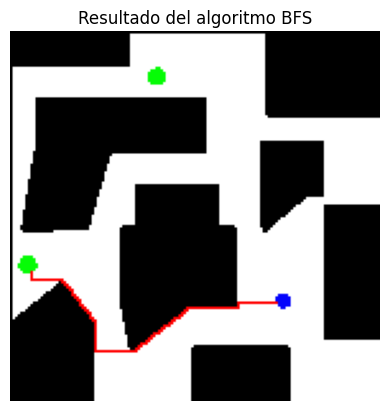

<Figure size 640x480 with 0 Axes>

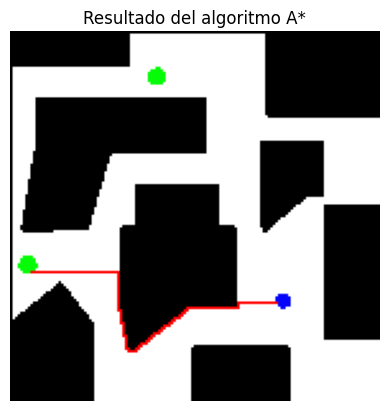

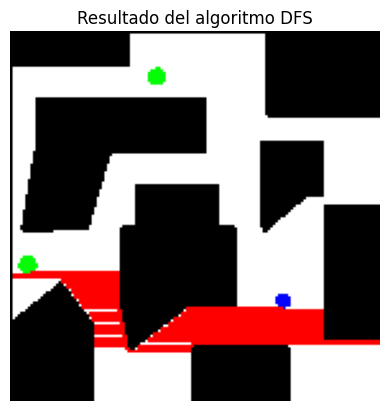

In [9]:
from abc import ABC, abstractmethod
from typing import List, Tuple
import numpy as np
from numpy.core.multiarray import array as array
from collections import deque  # Para usar colas en BFS
from discreta1 import *
import matplotlib.pyplot as plt


class Pathfinder(ABC):
    def __init__(self, image_matrix, target_color, start_color):
        self.image_matrix = image_matrix
        self.target_color = target_color
        self.start_color = start_color
        self.steps = []  # Guardar cada paso
        self.start = None
        self.end = None
        self.find_start_and_end()  # Encuentra las posiciones de inicio y final al instanciar

    def find_start_and_end(self):
        rows, cols, _ = self.image_matrix.shape
        for i in range(rows):
            for j in range(cols):
                if (self.image_matrix[i, j] == self.start_color).all():
                    self.start = (i, j)
                elif (self.image_matrix[i, j] == self.target_color).all():
                    self.end = (i, j)
                if self.start and self.end:
                    return  # Salir si ambos, inicio y final, son encontrados

class BFS(Pathfinder):
    def es_color_similar(self, pixel, color_objetivo, tolerancia=30):
        return all(abs(pixel[i] - color_objetivo[i]) <= tolerancia for i in range(3))

    def es_pared(self, pixel, umbral=50):
        return np.all(pixel[:3] <= umbral) 

    def es_posicion_valida(self, pos, visitados):
        i, j = pos
        rows, cols, _ = self.image_matrix.shape
        return 0 <= i < rows and 0 <= j < cols and pos not in visitados and not self.es_pared(self.image_matrix[i, j])

    def findPath(self) -> Tuple[List[np.array], np.ndarray]:
        if self.start is None or self.end is None:
            return [], None  

        rows, cols, _ = self.image_matrix.shape
        visited = set()
        queue = deque([(self.start, [self.start])])  # Cola para BFS, contiene pares (posición, camino)

        while queue:
            (current, path) = queue.popleft()
            x, y = current

            if (x, y) in visited:
                continue

            # Marcar como visitado
            visited.add((x, y))
            # Añadir el estado actual a los pasos
            self.steps.append((path, self.image_matrix.copy()))

            # Revisar si hemos llegado al final
            if self.es_color_similar(self.image_matrix[x, y], self.target_color):
                return self.steps, np.array(path)

            # Agregar vecinos a la cola
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # Arriba, abajo, izquierda, derecha
                nx, ny = x + dx, y + dy
                if self.es_posicion_valida((nx, ny), visited):
                    queue.append(((nx, ny), path + [(nx, ny)]))

        return [], None  # No se encontró camino



    
original_image = cv2.imread('Test2.bmp') 
discrete_image = convert_image_to_cells(original_image, cell_size=4)  
pf_bfs = BFS(discrete_image, [4, 4, 252], [6, 252, 6])  # Instancia de BFS con la imagen procesada
res_bfs = pf_bfs.findPath()  # Ejecución de la búsqueda BFS


if res_bfs:
    steps_bfs, final_path_bfs = res_bfs
    image_for_bfs = np.copy(discrete_image) 
    if final_path_bfs is not None:
        for position in final_path_bfs:
            x, y = position
            image_for_bfs[x, y] = [255, 0, 0] 

        plt.figure()  
        plt.imshow(image_for_bfs)
        plt.axis('off') 
        plt.title('Resultado del algoritmo BFS')
        plt.show()
else:
    print("No se encontró un camino con BFS.")

import heapq  # Necesario para la cola de prioridad en A*
class AStar(Pathfinder):
    def es_color_similar(self, pixel, color_objetivo, tolerancia=30):
        return all(abs(pixel[i] - color_objetivo[i]) <= tolerancia for i in range(3))

    def es_pared(self, pixel, umbral=50):
        return np.all(pixel[:3] <= umbral)

    def es_posicion_valida(self, pos, visitados):
        # Verifica si una posición es válida (dentro de los límites y no es una pared ni ha sido visitada).
        i, j = pos
        rows, cols, _ = self.image_matrix.shape
        return 0 <= i < rows and 0 <= j < cols and pos not in visitados and not self.es_pared(self.image_matrix[i, j])

    def heuristica(self, a, b):
        # Utilizamos la heurística de Manhattan 
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def findPath(self) -> Tuple[List[np.array], np.ndarray]:
        if self.start is None or self.end is None:
            return [], None  #

        rows, cols, _ = self.image_matrix.shape
        open_set = []
        heapq.heappush(open_set, (0 + self.heuristica(self.start, self.end), 0, self.start, [self.start]))  # Cola de prioridad
        visited = set()
        g_score = {self.start: 0}  

        while open_set:
            _, cost, current, path = heapq.heappop(open_set)
            x, y = current

            if current in visited:
                continue

            self.steps.append((path, self.image_matrix.copy()))
            if self.es_color_similar(self.image_matrix[x, y], self.target_color):
                return self.steps, np.array(path)

            visited.add(current)

      
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = x + dx, y + dy
                if self.es_posicion_valida((nx, ny), visited):
                    next_g = g_score[current] + 1  
                    if next_g < g_score.get((nx, ny), float('inf')):
                        g_score[(nx, ny)] = next_g
                        f_score = next_g + self.heuristica((nx, ny), self.end)
                        heapq.heappush(open_set, (f_score, next_g, (nx, ny), path + [(nx, ny)]))

        return [], None  # No se encontró camino

pf_astar = AStar(discrete_image, [4, 4, 252], [6, 252, 6])  # Instancia de AStar con la imagen procesada
res_astar = pf_astar.findPath()  # Ejecución de la búsqueda A*
plt.clf()  # Limpia la figura completa


pf_astar = AStar(discrete_image, [4, 4, 252], [6, 252, 6])  # Instancia de AStar con la imagen procesada
res_astar = pf_astar.findPath()  # Ejecución de la búsqueda A*

# Visualización del resultado de A*
if res_astar:
    steps_astar, final_path_astar = res_astar
    image_for_astar = np.copy(discrete_image) 
    if final_path_astar is not None:
        for position in final_path_astar:
            x, y = position
            image_for_astar[x, y] = [255, 0, 0] 

        plt.figure()  
        plt.imshow(image_for_astar)
        plt.axis('off')  
        plt.title('Resultado del algoritmo A*')
        plt.show()
else:
   print("No se encontró un camino con A*.")


class DFS(Pathfinder):
    def es_color_similar(self, pixel, color_objetivo, tolerancia=30):
        # Verifica si el color de un pixel es similar al color objetivo dentro de una tolerancia.
        return all(abs(pixel[i] - color_objetivo[i]) <= tolerancia for i in range(3))

    def es_pared(self, pixel, umbral=50):
        # Determina si un pixel se considera una pared basándose en un umbral.
        return np.all(pixel[:3] <= umbral)

    def es_posicion_valida(self, pos, visitados):
        # Verifica si una posición es válida (dentro de los límites y no es una pared ni ha sido visitada).
        i, j = pos
        rows, cols, _ = self.image_matrix.shape
        return 0 <= i < rows and 0 <= j < cols and pos not in visitados and not self.es_pared(self.image_matrix[i, j])

    def findPath(self) -> Tuple[List[np.array], np.ndarray]:
        if self.start is None or self.end is None:
            return [], None  # No hay inicio o fin definido

        rows, cols, _ = self.image_matrix.shape
        visited = set()
        stack = [(self.start, [self.start])]  # Pila para DFS, contiene pares (posición, camino)

        while stack:
            (current, path) = stack.pop()  # Se utiliza pop para obtener el último elemento añadido
            x, y = current

            if (x, y) in visited:
                continue

            # Marcar como visitado
            visited.add((x, y))
            # Añadir el estado actual a los pasos
            self.steps.append((path, self.image_matrix.copy()))

            # Revisar si hemos llegado al final
            if self.es_color_similar(self.image_matrix[x, y], self.target_color):
                return self.steps, np.array(path)

            # Agregar vecinos a la pila
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = x + dx, y + dy
                if self.es_posicion_valida((nx, ny), visited):
                    stack.append(((nx, ny), path + [(nx, ny)]))

        return [], None  # No se encontró camino




# Ejecución del algoritmo DFS
pf_dfs = DFS(discrete_image, [4, 4, 252], [6, 252, 6])
res_dfs = pf_dfs.findPath()  # Ejecución de la búsqueda DFS

# Visualización del resultado de DFS
if res_dfs:
    steps_dfs, final_path_dfs = res_dfs
    image_for_dfs = np.copy(discrete_image)  # Crea una copia fresca de la imagen para dibujar
    if final_path_dfs is not None:
        for position in final_path_dfs:
            x, y = position
            image_for_dfs[x, y] = [255, 0, 0] 

        plt.figure()  # Crea una nueva figura
        plt.imshow(image_for_dfs)
        plt.axis('off')  # Ocultar los ejes para una mejor visualización
        plt.title('Resultado del algoritmo DFS')
        plt.show()
else:
    print("No se encontró un camino con DFS.")




Imagen:Prueba Lab1

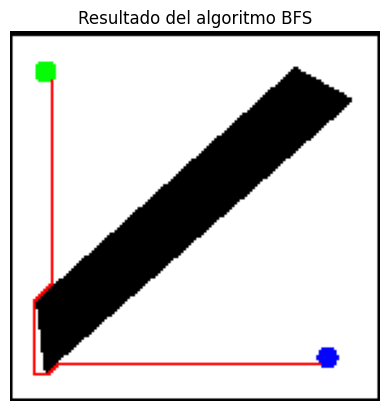

<Figure size 640x480 with 0 Axes>

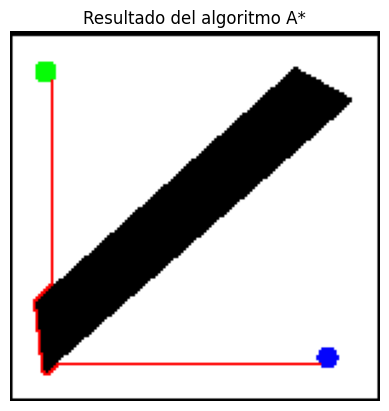

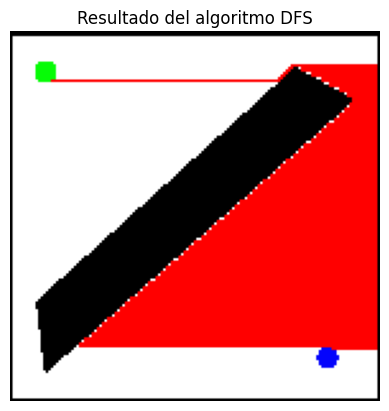

In [8]:
from abc import ABC, abstractmethod
from typing import List, Tuple
import numpy as np
from numpy.core.multiarray import array as array
from collections import deque  # Para usar colas en BFS
from discreta2 import *
import matplotlib.pyplot as plt


class Pathfinder(ABC):
    def __init__(self, image_matrix, target_color, start_color):
        self.image_matrix = image_matrix
        self.target_color = target_color
        self.start_color = start_color
        self.steps = []  # Guardar cada paso
        self.start = None
        self.end = None
        self.find_start_and_end()  # Encuentra las posiciones de inicio y final al instanciar

    def find_start_and_end(self):
        rows, cols, _ = self.image_matrix.shape
        for i in range(rows):
            for j in range(cols):
                if (self.image_matrix[i, j] == self.start_color).all():
                    self.start = (i, j)
                elif (self.image_matrix[i, j] == self.target_color).all():
                    self.end = (i, j)
                if self.start and self.end:
                    return  # Salir si ambos, inicio y final, son encontrados

class BFS(Pathfinder):
    def es_color_similar(self, pixel, color_objetivo, tolerancia=30):
        return all(abs(pixel[i] - color_objetivo[i]) <= tolerancia for i in range(3))

    def es_pared(self, pixel, umbral=50):
        return np.all(pixel[:3] <= umbral) 

    def es_posicion_valida(self, pos, visitados):
        i, j = pos
        rows, cols, _ = self.image_matrix.shape
        return 0 <= i < rows and 0 <= j < cols and pos not in visitados and not self.es_pared(self.image_matrix[i, j])

    def findPath(self) -> Tuple[List[np.array], np.ndarray]:
        if self.start is None or self.end is None:
            return [], None  

        rows, cols, _ = self.image_matrix.shape
        visited = set()
        queue = deque([(self.start, [self.start])])  # Cola para BFS, contiene pares (posición, camino)

        while queue:
            (current, path) = queue.popleft()
            x, y = current

            if (x, y) in visited:
                continue

            # Marcar como visitado
            visited.add((x, y))
            # Añadir el estado actual a los pasos
            self.steps.append((path, self.image_matrix.copy()))

            # Revisar si hemos llegado al final
            if self.es_color_similar(self.image_matrix[x, y], self.target_color):
                return self.steps, np.array(path)

            # Agregar vecinos a la cola
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # Arriba, abajo, izquierda, derecha
                nx, ny = x + dx, y + dy
                if self.es_posicion_valida((nx, ny), visited):
                    queue.append(((nx, ny), path + [(nx, ny)]))

        return [], None  # No se encontró camino



    
original_image = cv2.imread('Prueba Lab1.bmp') 
discrete_image = convert_image_to_cells(original_image, cell_size=4)  
pf_bfs = BFS(discrete_image, [4, 4, 252], [6, 252, 6])  # Instancia de BFS con la imagen procesada
res_bfs = pf_bfs.findPath()  # Ejecución de la búsqueda BFS


if res_bfs:
    steps_bfs, final_path_bfs = res_bfs
    image_for_bfs = np.copy(discrete_image) 
    if final_path_bfs is not None:
        for position in final_path_bfs:
            x, y = position
            image_for_bfs[x, y] = [255, 0, 0] 

        plt.figure()  
        plt.imshow(image_for_bfs)
        plt.axis('off') 
        plt.title('Resultado del algoritmo BFS')
        plt.show()
else:
    print("No se encontró un camino con BFS.")

import heapq  # Necesario para la cola de prioridad en A*
class AStar(Pathfinder):
    def es_color_similar(self, pixel, color_objetivo, tolerancia=30):
        return all(abs(pixel[i] - color_objetivo[i]) <= tolerancia for i in range(3))

    def es_pared(self, pixel, umbral=50):
        return np.all(pixel[:3] <= umbral)

    def es_posicion_valida(self, pos, visitados):
        # Verifica si una posición es válida (dentro de los límites y no es una pared ni ha sido visitada).
        i, j = pos
        rows, cols, _ = self.image_matrix.shape
        return 0 <= i < rows and 0 <= j < cols and pos not in visitados and not self.es_pared(self.image_matrix[i, j])

    def heuristica(self, a, b):
        # Utilizamos la heurística de Manhattan 
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def findPath(self) -> Tuple[List[np.array], np.ndarray]:
        if self.start is None or self.end is None:
            return [], None  #

        rows, cols, _ = self.image_matrix.shape
        open_set = []
        heapq.heappush(open_set, (0 + self.heuristica(self.start, self.end), 0, self.start, [self.start]))  # Cola de prioridad
        visited = set()
        g_score = {self.start: 0}  

        while open_set:
            _, cost, current, path = heapq.heappop(open_set)
            x, y = current

            if current in visited:
                continue

            self.steps.append((path, self.image_matrix.copy()))
            if self.es_color_similar(self.image_matrix[x, y], self.target_color):
                return self.steps, np.array(path)

            visited.add(current)

      
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = x + dx, y + dy
                if self.es_posicion_valida((nx, ny), visited):
                    next_g = g_score[current] + 1  
                    if next_g < g_score.get((nx, ny), float('inf')):
                        g_score[(nx, ny)] = next_g
                        f_score = next_g + self.heuristica((nx, ny), self.end)
                        heapq.heappush(open_set, (f_score, next_g, (nx, ny), path + [(nx, ny)]))

        return [], None  # No se encontró camino

pf_astar = AStar(discrete_image, [4, 4, 252], [6, 252, 6])  # Instancia de AStar con la imagen procesada
res_astar = pf_astar.findPath()  # Ejecución de la búsqueda A*
plt.clf()  # Limpia la figura completa


pf_astar = AStar(discrete_image, [4, 4, 252], [6, 252, 6])  # Instancia de AStar con la imagen procesada
res_astar = pf_astar.findPath()  # Ejecución de la búsqueda A*

# Visualización del resultado de A*
if res_astar:
    steps_astar, final_path_astar = res_astar
    image_for_astar = np.copy(discrete_image) 
    if final_path_astar is not None:
        for position in final_path_astar:
            x, y = position
            image_for_astar[x, y] = [255, 0, 0] 

        plt.figure()  
        plt.imshow(image_for_astar)
        plt.axis('off')  
        plt.title('Resultado del algoritmo A*')
        plt.show()
else:
   print("No se encontró un camino con A*.")



class DFS(Pathfinder):
    def es_color_similar(self, pixel, color_objetivo, tolerancia=30):
        # Verifica si el color de un pixel es similar al color objetivo dentro de una tolerancia.
        return all(abs(pixel[i] - color_objetivo[i]) <= tolerancia for i in range(3))

    def es_pared(self, pixel, umbral=50):
        # Determina si un pixel se considera una pared basándose en un umbral.
        return np.all(pixel[:3] <= umbral)

    def es_posicion_valida(self, pos, visitados):
        # Verifica si una posición es válida (dentro de los límites y no es una pared ni ha sido visitada).
        i, j = pos
        rows, cols, _ = self.image_matrix.shape
        return 0 <= i < rows and 0 <= j < cols and pos not in visitados and not self.es_pared(self.image_matrix[i, j])

    def findPath(self) -> Tuple[List[np.array], np.ndarray]:
        if self.start is None or self.end is None:
            return [], None  # No hay inicio o fin definido

        rows, cols, _ = self.image_matrix.shape
        visited = set()
        stack = [(self.start, [self.start])]  # Pila para DFS, contiene pares (posición, camino)

        while stack:
            (current, path) = stack.pop()  # Se utiliza pop para obtener el último elemento añadido
            x, y = current

            if (x, y) in visited:
                continue

            # Marcar como visitado
            visited.add((x, y))
            # Añadir el estado actual a los pasos
            self.steps.append((path, self.image_matrix.copy()))

            # Revisar si hemos llegado al final
            if self.es_color_similar(self.image_matrix[x, y], self.target_color):
                return self.steps, np.array(path)

            # Agregar vecinos a la pila
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = x + dx, y + dy
                if self.es_posicion_valida((nx, ny), visited):
                    stack.append(((nx, ny), path + [(nx, ny)]))

        return [], None  # No se encontró camino




# Ejecución del algoritmo DFS
pf_dfs = DFS(discrete_image, [4, 4, 252], [6, 252, 6])
res_dfs = pf_dfs.findPath()  # Ejecución de la búsqueda DFS

# Visualización del resultado de DFS
if res_dfs:
    steps_dfs, final_path_dfs = res_dfs
    image_for_dfs = np.copy(discrete_image)  # Crea una copia fresca de la imagen para dibujar
    if final_path_dfs is not None:
        for position in final_path_dfs:
            x, y = position
            image_for_dfs[x, y] = [255, 0, 0] 

        plt.figure()  # Crea una nueva figura
        plt.imshow(image_for_dfs)
        plt.axis('off')  # Ocultar los ejes para una mejor visualización
        plt.title('Resultado del algoritmo DFS')
        plt.show()
else:
    print("No se encontró un camino con DFS.")


